In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Initialize the dictionary to hold paths for each animal
image_paths = {}

# Base directory
base_path = "C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/JPEGImages/"

# List of animals to search for
animals = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]

# Traverse the directory structure
for dirname, _, filenames in os.walk(base_path):
    for animal in animals:
        # Check if the current directory contains the animal's name
        if animal in dirname:
            # Initialize the list if the animal is encountered for the first time
            if animal not in image_paths:
                image_paths[animal] = []
            # Add all image paths for the current animal
            for filename in filenames:
                image_paths[animal].append(os.path.join(dirname, filename))

# Print the paths for verification
for animal, paths in image_paths.items():
    print(f"{animal}: {len(paths)} images")

collie: 1028 images
dolphin: 946 images
elephant: 1038 images
fox: 664 images
giant+panda: 874 images
moose: 704 images
polar+bear: 868 images
rabbit: 1088 images
sheep: 1420 images
squirrel: 1200 images


In [3]:
for animal, paths in image_paths.items():
    print(f"{animal}: {paths}")

collie: ['C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/JPEGImages/collie\\collie_10001.jpg', 'C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/JPEGImages/collie\\collie_10002.jpg', 'C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/JPEGImages/collie\\collie_10003.jpg', 'C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/JPEGImages/collie\\collie_10004.jpg', 'C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/JPEGImages/collie\\collie_10005.jpg', 'C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/JPEGImages/collie\\collie_10006.jpg', 'C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/JPEGImages/collie\\collie_10007.jpg', 'C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/

In [4]:
# Output path for processed images
output_path = "C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/processed_images"
os.makedirs(output_path, exist_ok=True)

# Image size
image_size = (128, 128)  

# Choose first 650 image
for dirname, _, filenames in os.walk(base_path):
    for animal in animals:
        if animal in dirname:
            if animal not in image_paths:
                image_paths[animal] = []
            for filename in filenames:
                image_paths[animal].append(os.path.join(dirname, filename))

# Process first 650 images for all animal class
for animal, paths in image_paths.items():
    selected_paths = paths[:650]
    animal_output_dir = os.path.join(output_path, animal)
    os.makedirs(animal_output_dir, exist_ok=True)

    for i, image_path in enumerate(selected_paths):
        try:
            # Load image
            img = cv2.imread(image_path)

            # Resize and Normalize
            img_resized = cv2.resize(img, image_size)
            img_normalized = img_resized / 255.0

            # Create new file path
            output_file = os.path.join(animal_output_dir, f"{i+1}.jpg")

            # Save normalized image
            cv2.imwrite(output_file, (img_normalized * 255).astype("uint8"))
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

print("Images are successfully processed and saved.")

Images are successfully processed and saved.


In [5]:
def load_images(directory, image_size):
    X = []
    y = []
    label_map = {}  # Mapping class names for labeling
    current_label = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)

        if os.path.isdir(subdir_path):
            if subdir not in label_map:
                label_map[subdir] = current_label
                current_label += 1

            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)
                if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        # Load image and resize
                        img = cv2.imread(file_path)
                        img_resized = cv2.resize(img, image_size)
                        X.append(img_resized)
                        y.append(label_map[subdir])
                    except Exception as e:
                        print(f"Error loading image {file_path}: {e}")

    X = np.array(X, dtype=np.float32) / 255.0
    y = np.array(y, dtype=np.int32)
    return X, y

def manipulate_image(image):
    # Increase brightness
    manipulated_img = cv2.convertScaleAbs(image, alpha=1.5, beta=30)
    
    # White Balance
    wb = cv2.xphoto.createSimpleWB()
    manipulated_img = wb.balanceWhite(manipulated_img)

    # Increase contrast
    lab = cv2.cvtColor(manipulated_img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    lab = cv2.merge([l, a, b])
    manipulated_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return manipulated_img

In [6]:
def save_manipulated_images(input_dir, output_dir, image_size):
    os.makedirs(output_dir, exist_ok=True)

    for animal in os.listdir(input_dir):
        animal_dir = os.path.join(input_dir, animal)
        if os.path.isdir(animal_dir):
            output_animal_dir = os.path.join(output_dir, animal)
            os.makedirs(output_animal_dir, exist_ok=True)

            for image_file in os.listdir(animal_dir):
                image_path = os.path.join(animal_dir, image_file)
                if image_file.endswith((".jpg", ".png")):
                    try:
                        # Load image
                        img = cv2.imread(image_path)

                        # Manipulate
                        manipulated_img = manipulate_image(img)

                        # Create new file path
                        output_image_path = os.path.join(output_animal_dir, image_file)

                        # Save manipulated image
                        cv2.imwrite(output_image_path, manipulated_img)
                    except Exception as e:
                        print(f"Error processing {image_path}: {e}")

# Folder where manipulated images will be saved
output_dir = "C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/manipulated_images"
save_manipulated_images("C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/processed_images", output_dir, (128, 128))

In [7]:
# Load processed and manipulated images
processed_images_dir = "C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/processed_images"
manipulated_images_dir = "C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/manipulated_images"
image_size = (128, 128)

# Load images
X_processed, y_processed = load_images(processed_images_dir, image_size)
X_manipulated, y_manipulated = load_images(manipulated_images_dir, image_size)

# Concatenate images
X_combined = np.concatenate((X_processed, X_manipulated))
y_combined = np.concatenate((y_processed, y_manipulated))

print(f"Combined X shape: {X_combined.shape}, Combined y shape: {y_combined.shape}")

Combined X shape: (13000, 128, 128, 3), Combined y shape: (13000,)


In [8]:
# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

# Create model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(set(y_combined)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation to Train dataset
datagen.fit(X_train)

In [10]:
# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Accuracy for Test dataset
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/10
228/228 [==============================] - 7s 21ms/step - loss: 1.9204 - accuracy: 0.3049 - val_loss: 1.5962 - val_accuracy: 0.4418
Epoch 2/10
228/228 [==============================] - 4s 17ms/step - loss: 1.4550 - accuracy: 0.5048 - val_loss: 1.2764 - val_accuracy: 0.5709
Epoch 3/10
228/228 [==============================] - 4s 17ms/step - loss: 1.1745 - accuracy: 0.6025 - val_loss: 1.2419 - val_accuracy: 0.5786
Epoch 4/10
228/228 [==============================] - 4s 17ms/step - loss: 0.9645 - accuracy: 0.6743 - val_loss: 1.0141 - val_accuracy: 0.6681
Epoch 5/10
228/228 [==============================] - 4s 17ms/step - loss: 0.7215 - accuracy: 0.7523 - val_loss: 0.9223 - val_accuracy: 0.7093
Epoch 6/10
228/228 [==============================] - 4s 17ms/step - loss: 0.5487 - accuracy: 0.8132 - val_loss: 0.9019 - val_accuracy: 0.7451
Epoch 7/10
228/228 [==============================] - 4s 17ms/step - loss: 0.4236 - accuracy: 0.8606 - val_loss: 0.8953 - val_accuracy: 0.7434

In [11]:
# Load manipulated images
manipulated_images_dir = "C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/manipulated_images"
image_size = (128, 128)

X_manipulated, y_manipulated = load_images(manipulated_images_dir, image_size)

In [12]:
# Accuracy for Manipulated Images dataset
test_loss, test_acc = model.evaluate(X_manipulated, y_manipulated, verbose=2)
print(f"Test accuracy with manipulated data: {test_acc}")


204/204 - 1s - loss: 0.4969 - accuracy: 0.8948 - 1s/epoch - 6ms/step
Test accuracy with manipulated data: 0.8947691917419434


In [13]:
# Predict Manipulated Images dataset
predictions = model.predict(X_manipulated)

# Select the class with the highest probability for each prediction
predicted_classes = np.argmax(predictions, axis=1)

# Analyze correct and incorrect predictions
correct_predictions = (predicted_classes == y_manipulated).sum()
total_samples = len(y_manipulated)
print(f"Number of correctly predicted examples: {correct_predictions}/{total_samples}")


204/204 [==============================] - 1s 6ms/step
Number of correctly predicted examples: 5816/6500


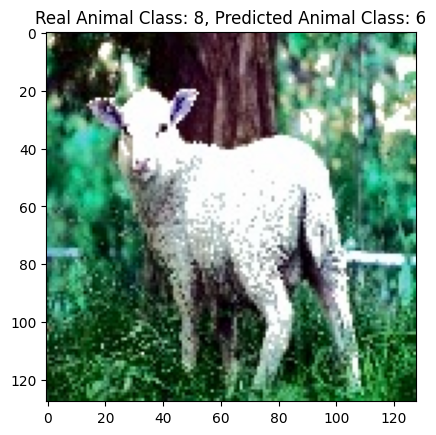

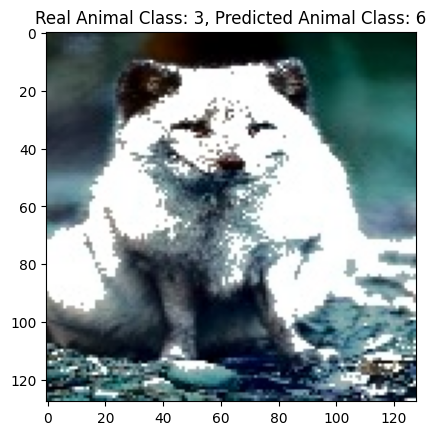

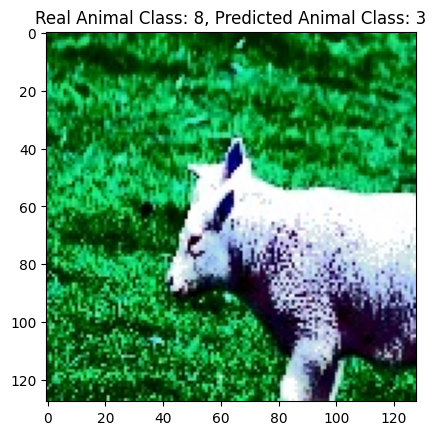

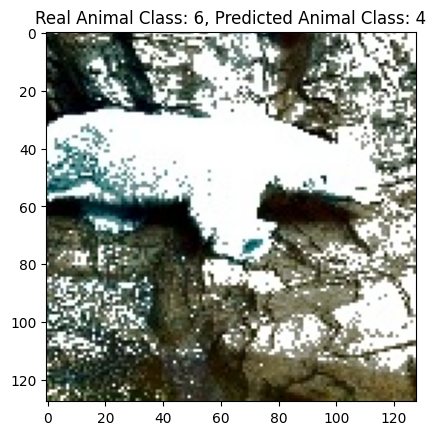

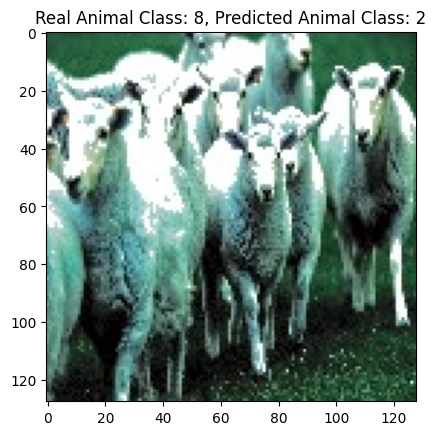

In [14]:
# Find incorrect predictions
incorrect_indices = np.where(predicted_classes != y_manipulated)[0]

# Show some incorrect predictions
random_indices = np.random.choice(incorrect_indices, 5, replace=False)

for idx in random_indices:
    plt.imshow(X_manipulated[idx])
    plt.title(f"Real Animal Class: {y_manipulated[idx]}, Predicted Animal Class: {predicted_classes[idx]}")
    plt.show()

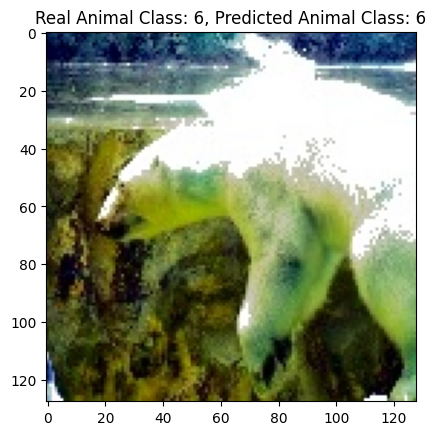

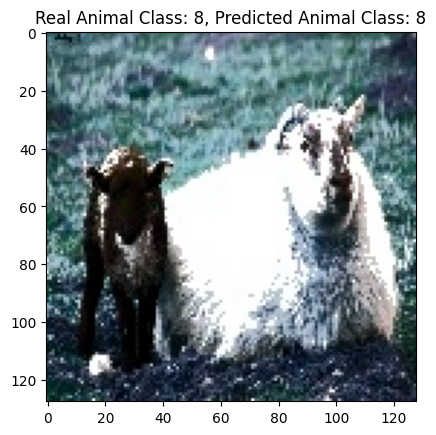

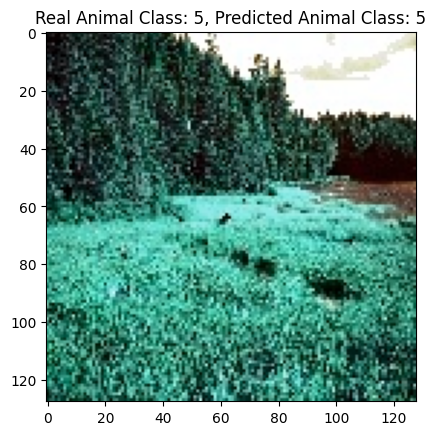

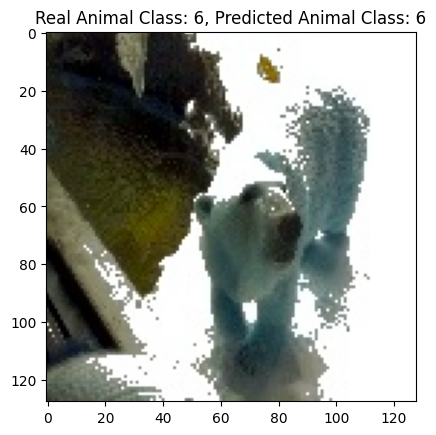

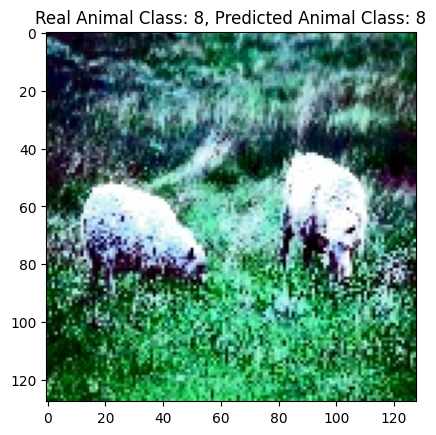

In [15]:
# Find correct predictions
correct_indices = np.where(predicted_classes == y_manipulated)[0]

# Show some correct predictions
random_indices = np.random.choice(correct_indices, 5, replace=False)

for idx in random_indices:
    plt.imshow(X_manipulated[idx])
    plt.title(f"Real Animal Class: {y_manipulated[idx]}, Predicted Animal Class: {predicted_classes[idx]}")
    plt.show()

In [16]:
def get_wb_images(image):
    # Calculate the average of each color channel
    avg_b = np.mean(image[:, :, 0])  # Blue
    avg_g = np.mean(image[:, :, 1])  # Green
    avg_r = np.mean(image[:, :, 2])  # Red
    
    # Average brightness
    avg_gray = (avg_b + avg_g + avg_r) / 3
    
    # Normalize channels
    scale_b = avg_gray / avg_b
    scale_g = avg_gray / avg_g
    scale_r = avg_gray / avg_r

    # Normalize images
    image[:, :, 0] = np.clip(image[:, :, 0] * scale_b, 0, 255)
    image[:, :, 1] = np.clip(image[:, :, 1] * scale_g, 0, 255)
    image[:, :, 2] = np.clip(image[:, :, 2] * scale_r, 0, 255)

    return image.astype(np.uint8)

In [17]:
# Directories of manipulated images and results
manipulated_images_dir = "C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/manipulated_images"
output_dir = "C:/Users/Melih/Coding/Bootcamp/Melih_Aygaz_Visual_Bootcamp/AwA2-data/Animals_with_Attributes2/wb_images"
os.makedirs(output_dir, exist_ok=True)

# Process the entire manipulated test set with color constancy and save it
for root, _, files in os.walk(manipulated_images_dir):
    for file in files:
        input_image_path = os.path.join(root, file)

        # Create subfolders to preserve the output folder structure
        relative_path = os.path.relpath(root, manipulated_images_dir)
        output_subdir = os.path.join(output_dir, relative_path)
        os.makedirs(output_subdir, exist_ok=True)
        
        output_image_path = os.path.join(output_subdir, file)

        # Load image
        image = cv2.imread(input_image_path)
        if image is not None:
            # Apply Gray World algorithm 
            wb_image = get_wb_images(image)
            # Save image
            cv2.imwrite(output_image_path, wb_image)

print("Color constancy has been applied to the entire manipulated test set.")

Color constancy has been applied to the entire manipulated test set.


In [18]:
def load_wb_images(wb_images_dir, image_size):
    X = []
    y = []
    for root, _, files in os.walk(wb_images_dir):
        for file in files:
            image_path = os.path.join(root, file)
            label = os.path.basename(root)  
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, image_size)
                X.append(image)
                y.append(animals.index(label))  
    return np.array(X), np.array(y)

# Load images
wb_X_test, wb_y_test = load_wb_images(output_dir, (128, 128))

In [19]:
# Normalize
wb_X_test = wb_X_test / 255.0

# Apply model to dataset
test_loss, test_acc = model.evaluate(wb_X_test, wb_y_test)
print(f"White balance applied test accuracy: {test_acc}")

204/204 [==============================] - 2s 8ms/step - loss: 8.4323 - accuracy: 0.3471
White balance applied test accuracy: 0.3470769226551056
